## HW_04: Cassidy Tao

This homework assignment guides you through building and evaluating machine learning models to predict individual income using the American Community Survey (ACS) microdata. You will implement both an XGBoost model and a fully connected neural network using Keras, following the workflows demonstrated in the provided tutorials. The focus will be on log-transforming the income target, feature engineering, model training, and evaluation.

## Setup

### Data
Use the ACS microdata file `usa_00005.dta` that I shared on Populi. This dataset contains individual-level records with demographic and socioeconomic features, including total personal income (`inctot`).

## Task 1: Load and Log-transform ACS Data

Following the final attempt in the XGBoost tutorial, sample 10% of the microdata, drop any rows where `inctot == 9999999`.

In [1]:
import pandas as pd
data = pd.read_stata(r"/home/RAND.ORG/ctao/Machine_Learning_2025/homework/usa_00005.dta")
data = data.sample(frac=0.1, random_state=42).reset_index(drop=True) # subset to 10% of the data
data = data[data['inctot'] != 9999999] #FIXED

__Quesion 1:__ Why is it not necessary to impute or filter our missing values for other features?

Answer: The descision tree model already handles missing values by categorizing/sorting them within the model.

### Task 1.1: Log-transform Income

Instead of predicting income directly, we will predict log-income.
Create a new target column `log_inctot` by applying the natural log transformation to `inctot` after adding 1 (i.e., `np.log1p`).
Filter out any rows where `inctot` is less than or equal to zero before applying the log transformation.
Make a histogram of both the original income and log-income distributions to visualize the effect of the transformation.

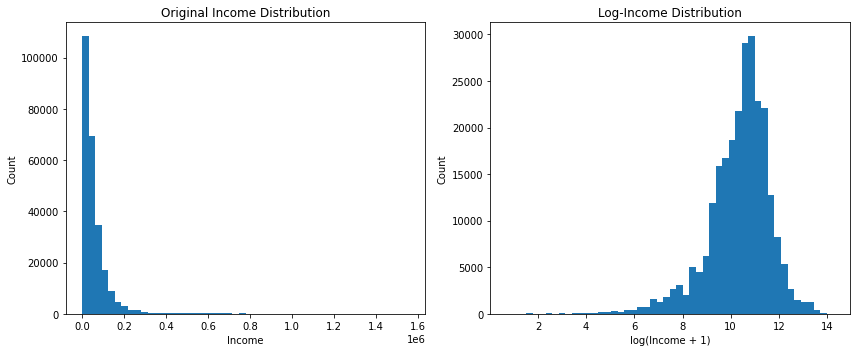

In [2]:
import matplotlib.pyplot as plt
import numpy as np
data = data[data["inctot"] > 0].copy() # Filter out non-positive inc
data["log_inctot"] = np.log1p(data["inctot"])

plt.figure(figsize=(12,5)) # 3. Plot hists
plt.subplot(1, 2, 1)
plt.hist(data["inctot"], bins=50)
plt.title("Original Income Distribution")
plt.xlabel("Income")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(data["log_inctot"], bins=50)
plt.title("Log-Income Distribution")
plt.xlabel("log(Income + 1)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

__Question 2:__ What are the advantages of predicting log-income rather than income directly?

Answer: Log income allows for the information to be displayed more clearly, since an absolute scale drowns out smaller values with the exponentially increasing hights of the distribution.

## Task 2: Feature Engineering and Encoding
Split the data into a feature matrix `X` and target vector `y` (the log-income column created above). Perform one-hot encoding on all categorical features, dropping sparse columns whose proportion of non-zero entries falls below 1%.

The feature matrix `X` should include all columns except `inctot` and `log_inctot`.
The target vector `y` should be the `log_inctot` column.
Mimic the one-hot encoding workflow from the tutorial: build dummies for every categorical column in `X`, then drop sparse columns whose proportion of non-zero entries falls below 1%.


In [3]:
X = data.drop(columns=['inctot','log_inctot','cbserial','cluster','serial','countyfip','statefip']) #Caused neural network to fail
y = data['log_inctot']

X_encoded = pd.get_dummies(X, drop_first=False)
cols_to_keep = [col for col in X_encoded.columns if (X_encoded[col] != 0).mean() > 0.01]
X_encoded = X_encoded[cols_to_keep]

### Task 2.1: Train/Test Split
Split the encoded data into training and testing sets (80/20).

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
#print(X_train.max()) # Check for huge values

## Task 3: XGBoost Modeling (Log Target)
Reproduce the final modeling attempt from `examples/XGBoost.ipynb`, but treat the log-income target as the label. Work through the following subtasks and insert your own code in each block.


In [5]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Task 3.2: Hyperparameter Dictionary
Start from the tutorial’s baseline settings (e.g., `eta = 1`, `max_depth = 10`, `min_child_weight = 100`, RMSE metric, early stopping after 50 rounds) and justify any deviations you make.
Use the `reg:squarederror` objective and `rmse` evaluation metric.

In [6]:
params = {'eta': 1, 'max_depth': 10,'min_child_weight': 100,
        'objective': 'reg:squarederror','eval_metric': 'rmse',
        'verbosity': 2,'tree_method':'gpu_hist',
        'predictor':'gpu_predictor'}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10000
early_stopping_rounds = 50

In [7]:
bst = xgb.train(params,dtrain,num_round,evallist,
        early_stopping_rounds=early_stopping_rounds)

[0]	train-rmse:0.89170	eval-rmse:0.89646
[1]	train-rmse:0.86653	eval-rmse:0.87565
[2]	train-rmse:0.84787	eval-rmse:0.86312
[3]	train-rmse:0.84002	eval-rmse:0.85896
[4]	train-rmse:0.82921	eval-rmse:0.85553
[5]	train-rmse:0.82097	eval-rmse:0.85373
[6]	train-rmse:0.81653	eval-rmse:0.85481
[7]	train-rmse:0.81306	eval-rmse:0.85449
[8]	train-rmse:0.80919	eval-rmse:0.85398
[9]	train-rmse:0.80562	eval-rmse:0.85292
[10]	train-rmse:0.80344	eval-rmse:0.85331
[11]	train-rmse:0.80032	eval-rmse:0.85402
[12]	train-rmse:0.79802	eval-rmse:0.85443
[13]	train-rmse:0.79639	eval-rmse:0.85500
[14]	train-rmse:0.79426	eval-rmse:0.85562
[15]	train-rmse:0.79214	eval-rmse:0.85638
[16]	train-rmse:0.78879	eval-rmse:0.85734
[17]	train-rmse:0.78593	eval-rmse:0.85922
[18]	train-rmse:0.78413	eval-rmse:0.86057
[19]	train-rmse:0.78231	eval-rmse:0.86171
[20]	train-rmse:0.78029	eval-rmse:0.86301
[21]	train-rmse:0.77769	eval-rmse:0.86448
[22]	train-rmse:0.77589	eval-rmse:0.86518
[23]	train-rmse:0.77328	eval-rmse:0.86591
[2

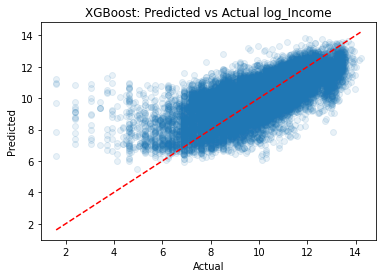

In [8]:
y_pred_plt = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_test_plt = y_test

plt.scatter(y_test_plt, y_pred_plt, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Predicted vs Actual log_Income")
plt.plot([y_test_plt.min(), y_test_plt.max()], [y_test_plt.min(), y_test_plt.max()], 'r--')
plt.show()

### Task 3.3: Hyperparameter Tuning

Perform a grid search over the `eta = [1, 0.1, 0.01]` and `max_depth = [3, 6, 10]` parameters to identify the best combination based on validation RMSE (i.e., for each combination of `eta` and `max_depth`, train a model and record the validation RMSE).
Use early stopping with a patience of 50 rounds and a maximum of 10,000 training rounds.

In [9]:
import xgboost as xgb
import numpy as np

etas = [1, 0.1, 0.01]
depths = [3, 6, 10]
results = {}
dtrain = xgb.DMatrix(X_train, label=y_train)
for eta in etas:
    for depth in depths:
        params = {'eta': eta,'max_depth': depth,
            'min_child_weight': 100,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse','verbosity': 1,
            'tree_method':'gpu_hist',
            'predictor':'gpu_predictor'}
        evallist = [(dtrain, 'train'), (dtest, 'eval')]
        model = xgb.train(params,dtrain,
            num_boost_round=10000,
            evals=evallist,
            early_stopping_rounds=50,
            verbose_eval=False)

        rmse = model.best_score
        results[(eta, depth)] = rmse
        print((eta, depth), rmse)

best_combo = min(results, key=results.get)
best_rmse = results[best_combo]

print("Best:", best_combo, best_rmse)

(1, 3) 0.825681
(1, 6) 0.842447
(1, 10) 0.85292
(0.1, 3) 0.8053
(0.1, 6) 0.803274
(0.1, 10) 0.803266
(0.01, 3) 0.812876
(0.01, 6) 0.80227
(0.01, 10) 0.801323
Best: (0.01, 10) 0.801323


__Question 3:__ Which hyperparameter combination yielded the lowest validation RMSE, and what was that RMSE value?
Based on the results, do you think you need to expand the grid search other values or parameters?
(Note: You do not need to actually search for more parameters, just discuss.)

Answer: The best RMSE score is 0.8, obtained with a eta hyperparameter of 0.01 and depth of 10. Based on the result, I don't think a further search is necessarily required. A RMSE of 0.8 says that the residuals are fairly small already, and further adjustment could simply lead to overfitting or extra time consumed.

### Task 3.4: Final Model Training
Using the best hyperparameters from Task 3.3, train a final XGBoost model on the full dataset.

In [10]:
params = {'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 100,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 2,
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor'}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10000
early_stopping_rounds = 50

bst = xgb.train(params,dtrain,num_round,evallist,
        early_stopping_rounds=early_stopping_rounds)

y_pred_plt = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_test_plt = y_test

[0]	train-rmse:9.85143	eval-rmse:9.85500
[1]	train-rmse:9.75377	eval-rmse:9.75731
[2]	train-rmse:9.65709	eval-rmse:9.66060
[3]	train-rmse:9.56140	eval-rmse:9.56486
[4]	train-rmse:9.46666	eval-rmse:9.47009
[5]	train-rmse:9.37288	eval-rmse:9.37628
[6]	train-rmse:9.28005	eval-rmse:9.28340
[7]	train-rmse:9.18815	eval-rmse:9.19146
[8]	train-rmse:9.09718	eval-rmse:9.10045
[9]	train-rmse:9.00712	eval-rmse:9.01035
[10]	train-rmse:8.91797	eval-rmse:8.92116
[11]	train-rmse:8.82972	eval-rmse:8.83288
[12]	train-rmse:8.74236	eval-rmse:8.74548
[13]	train-rmse:8.65588	eval-rmse:8.65897
[14]	train-rmse:8.57027	eval-rmse:8.57333
[15]	train-rmse:8.48553	eval-rmse:8.48855
[16]	train-rmse:8.40165	eval-rmse:8.40464
[17]	train-rmse:8.31860	eval-rmse:8.32156
[18]	train-rmse:8.23640	eval-rmse:8.23933
[19]	train-rmse:8.15504	eval-rmse:8.15793
[20]	train-rmse:8.07448	eval-rmse:8.07736
[21]	train-rmse:7.99475	eval-rmse:7.99759
[22]	train-rmse:7.91582	eval-rmse:7.91863
[23]	train-rmse:7.83769	eval-rmse:7.84047
[2

### Task 3.5: Evaluate Predictions
Plot predicted vs. actual log-income values on the test set using a scatter plot.

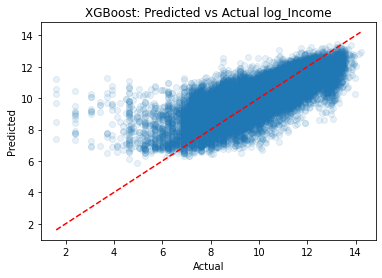

In [11]:
plt.scatter(y_test_plt, y_pred_plt, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Predicted vs Actual log_Income")
plt.plot([y_test_plt.min(), y_test_plt.max()], [y_test_plt.min(), y_test_plt.max()], 'r--')  # diagonal line
plt.show()

__Question 4:__ Qualitatively, how well do the predictions align with the actual values?

The predictions and outcomes align reasonably well. There is somewhat of an ellipse rather than a full correlation. But too small an error would be a sign of overfitting, so the model appears fairly strong.

## Task 4: Neural Network Modeling (Keras)
Use the structure from `examples/neural_nets_simple.ipynb` to fit a fully connected neural network on the same encoded features and log-income target.
Use the same train/test split as in Task 2.1.

### Task 4.1: Prepare Data for Keras
If necessary, convert the training and test feature matrices and target vectors into NumPy arrays suitable for Keras.
__Note:__ You may have already done this in Task 2.1.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
X_scaler = StandardScaler()

X_train_np = X_train.astype("float32")
X_test_np  = X_test.astype("float32")

X_train_scaled = X_scaler.fit_transform(X_train_np)
X_test_scaled  = X_scaler.transform(X_test_np)

y_scaler = StandardScaler()

y_train_np = y_train.astype("float32")
y_test_np  = y_test.astype("float32")

y_train_scaled = y_scaler.fit_transform(y_train_np.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test_np.values.reshape(-1, 1))

model = keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(X_train_np.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)  ])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse")

__Question 5:__ What should the input dimension be for the first layer of the network be? 

Answer: The input dimension should be the same as the number of columns of the training/testing data (X).

### Task 4.3: Initial Training
Fit the model on the training data while validating on the test set.
Run the training for a maximum of 1,000 epochs.
I have some example code below that includes early stopping to prevent overfitting.
You may adjust as needed.

The `patience` parameter in the `EarlyStopping` callback controls how many epochs with no improvement on the validation loss to wait before stopping training.
The `batch_size` is a parameter that we haven't discussed in class, but it limits the amount of data the model is exposed to at once during training.
You can leave it at 1024 for this assignment.

In [14]:
#print(tf.config.list_physical_devices('GPU'))

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled),
    epochs=10000,batch_size=1024,verbose=1,callbacks=[early_stop])


Epoch 1/10000
199/199 [==============================] - 1s 6ms/step - loss: 0.4875 - val_loss: 0.4375
Epoch 2/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.4125 - val_loss: 0.4341
Epoch 3/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.3879 - val_loss: 0.4357
Epoch 4/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.3649 - val_loss: 0.4510
Epoch 5/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.3413 - val_loss: 0.4586
Epoch 6/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.3179 - val_loss: 0.4598
Epoch 7/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.2964 - val_loss: 0.4692
Epoch 8/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.2754 - val_loss: 0.4819
Epoch 9/10000
199/199 [==============================] - 1s 3ms/step - loss: 0.2591 - val_loss: 0.4925
Epoch 10/10000
199/199 [==============================] - 1s 3ms/step - l

#### Task 4.3a
Plot the training and validation loss curves over epochs.

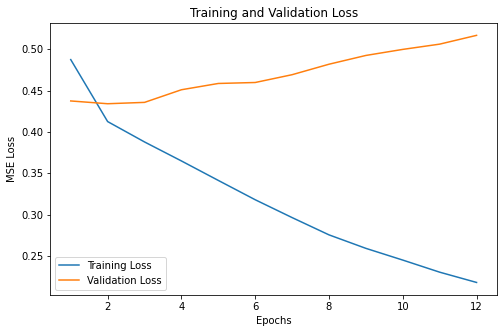

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

__Question 6:__ Based on the loss curves, does the model appear to be underfitting, overfitting, or well-fitted? Justify your answer.

Answer: The consistently decreasing training loss and increasing validation loss indicates overfitting. Increasing validation loss after a local minima indicates that the model is losing accuracy on the testing set while getting increasingly overfitting itself to the training set. This indicates that the model is becoming too specialized to the training data and less generalizable to unseen data.

### Task 4.4: Model Tuning
The neural network architecture and training parameters can significantly impact performance.
The architecture consists of the number of layers, layer dimensions, and activation functions.
Create three different architectures: the one from Task 4.2, a deeper/wider one, and a shallower/narrower one.
Additionally, consider three different learning rates: `1e-3`, `1e-4`, and `1e-5`.

Perform a grid search over these architectures and learning rates to identify the best combination based on validation loss.

__Hint:__ Save the models and their histories in a dictionary for easy comparison later.

In [17]:
architectures = {"large": [256, 128, 64],
                 "medium": [128, 64],
                 "small": [64, 32]}
learning_rates = [1e-3, 1e-4,1e-5]
results = {}

for arch_name, layers_dims in architectures.items():
    for lr in learning_rates:

        model = keras.Sequential()
        model.add(layers.Dense(layers_dims[0], activation="relu", input_shape=(X_train_scaled.shape[1],)))
        for dim in layers_dims[1:]:
            model.add(layers.Dense(dim, activation="relu"))
        model.add(layers.Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')

        early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        history = model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_test_scaled, y_test_scaled),
            epochs=200, batch_size=512,
            verbose=0, callbacks=[early_stop])
        results[(arch_name, lr)] = {"model": model, "history": history}
        print(f"Trained {arch_name} lr={lr} best val_loss={min(history.history['val_loss']):.4f}")

Trained large lr=0.001 best val_loss=0.4315
Trained large lr=0.0001 best val_loss=0.4495
Trained large lr=1e-05 best val_loss=0.4552
Trained medium lr=0.001 best val_loss=0.4401
Trained medium lr=0.0001 best val_loss=0.4491
Trained medium lr=1e-05 best val_loss=0.4599
Trained small lr=0.001 best val_loss=0.4340
Trained small lr=0.0001 best val_loss=0.4429
Trained small lr=1e-05 best val_loss=0.4499


In [18]:
best_val_loss = np.inf
best_model = None
best_config = None

for config, result in results.items():
    val_loss = min(result['history'].history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = result['model']
        best_config = config

print(f"Best model: {best_config}, val_loss={best_val_loss:.4f}")

Best model: ('large', 0.001), val_loss=0.4315


__Question 7:__ Which architecture and learning rate combination yielded the lowest validation loss, and what was that loss value?

The lowest validation loss was achieved by the large model with learning rate = 0.001. It achieved a loss of 0.4315

### Task 4.5: Evaluate Predictions
Generate predictions on the test set using the best model from Task 4.
Create a scatter plot of predicted vs. actual log-income values.

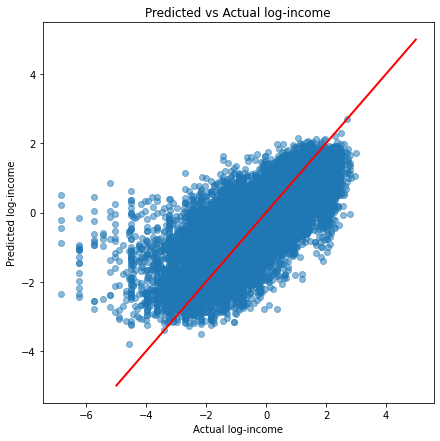

In [19]:
y_pred = best_model.predict(X_test_scaled)
plt.figure(figsize=(7,7))
plt.scatter(y_test_scaled, y_pred, alpha=0.5)
plt.plot([-5, 5],
         [-5, 5],
         color='red', linewidth=2)  # 45-degree line for perfect prediction
plt.xlabel('Actual log-income')
plt.ylabel('Predicted log-income')
plt.title('Predicted vs Actual log-income')
plt.show()

## Task 5: Model Comparison and Reflection
Which model would you choose for predicting log-income on new ACS data: the XGBoost model from Task 3 or the neural network from Task 4? Why?

Answer: I would choose the xgboost descision tree model. It displayed a comparable fit to the data (note the neural net is scaled in the plot above), and did not require scaling/gpu acceleration to be manageable. It makes up for its lack of complexity by being more robust and easier to handle.